- Reference
  - Blog: https://work-in-progress.hatenablog.com/entry/2019/04/06/113629
  - Source: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
  - Source: https://github.com/eriklindernoren/Keras-GAN/pull/117
    - Added functionality to save/load Keras model for intermittent training.

In [2]:
import os

In [3]:
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/saved_models', exist_ok=True)

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import Adam

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [6]:
class GAN():
    def __init__(self):
        self.history = pd.DataFrame({}, columns=['d_loss', 'acc', 'g_loss'])

        self.img_save_dir = 'data/images'
        self.model_save_dir = 'data/saved_models'
        self.discriminator_name = 'discriminator_model'
        self.generator_name = 'generator_model'
        self.combined_name = 'combined_model'

        self.discriminator = None
        self.generator = None
        self.combined = None

        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

    def init(self, loading=False):
        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        if loading:
            self.load_model_weight(self.discriminator_name)

        self.generator = self.build_generator()
        if loading:
            self.load_model_weight(self.generator_name)

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.summary()
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        if loading:
            self.load_model_weight(self.combined_name)

    def build_generator(self):
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=-1, save_interval=-1):
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()
        #print(X_train.shape)

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        #print(X_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        print(datetime.datetime.now().isoformat(), 'Epoch Start')

        for epoch in range(epochs):
            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)

            self.history = self.history.append({'d_loss': d_loss[0], 'acc': d_loss[1], 'g_loss': g_loss}, ignore_index=True)

            if sample_interval > 0 and epoch % sample_interval == 0:
                print(datetime.datetime.now().isoformat(), '%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

            if save_interval > 0 and epoch != 0 and epoch % save_interval == 0:
                self.save_model_weights_all()
                
        print(datetime.datetime.now().isoformat(), 'Epoch End')

    def generate_image(self):
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        return self.generator.predict(noise)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1

        file_name = '{}.png'.format(epoch)
        file_path = os.path.join(self.img_save_dir, file_name)
        fig.savefig(file_path)

        plt.close()

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'acc', 'g_loss']
        self.history[columns].plot()
 
    def save_model_weights_all(self):
        self.save_model_weights(self.discriminator, self.discriminator_name)
        self.save_model_weights(self.generator, self.generator_name)
        self.save_model_weights(self.combined, self.combined_name)

    def save_model_weights(self, model, model_name):
        weights_path = os.path.join(self.model_save_dir, '{}.h5'.format(model_name))
        model.save_weights(weights_path)

        print('Weights saved.', model_name)

    def load_model_weight(self, model_name):
        model = None

        if model_name == self.discriminator_name:
            model = self.discriminator
        elif model_name == self.generator_name:
            model = self.generator
        elif model_name == self.combined_name:
            model = self.combined

        if not model:
            print('Model is not initialized.', model_name)
            return

        weights_path = os.path.join(self.model_save_dir, '{}.h5'.format(model_name))

        if not os.path.exists(weights_path):
            print('Not found h5 file.', model_name)
            return

        model.load_weights(weights_path)

        print('Weights loaded.', model_name)

In [7]:
gan = GAN()
gan.init(loading=True)
#gan.train(epochs=500, batch_size=32, sample_interval=50, save_interval=50)
#gan.train(epochs=500, batch_size=32, sample_interval=50)
#gan.save_model_weights_all()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
__________________________________________________

In [8]:
gen_img = gan.generate_image()

In [9]:
gen_img.shape

(1, 28, 28, 1)

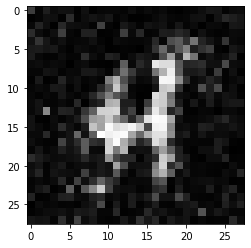

In [11]:
plt.imshow(gen_img[0], cmap='gray')

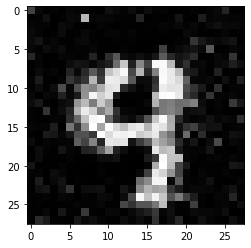

In [14]:
plt.imshow((gan.generate_image())[0], cmap='gray')